---
title: "Optimal Group Project Assignment"
date: 2025-07-31
format: html
categories:
- optimization
draft: false
jupyter: python3
---

My senior design project was essentially randomly assigned. 

The professor gave us a list of potential projects and told us to group up and rank our top five. When we got our assignments, I was a bit disappointed and confused because I got a project that I did not list on my preferences (something to do with measuring strain using digital image correlation). Stranger still, there had been other people that wanted our project. The professor said that the decisions were final. When asked, he said he ran a monte carlo simulation and picked the one that looked the best. We're not exactly sure what criteria he used, but the result was that many students were suboptimally assigned.

Years later, I sometimes think of this, and having TA'd some courses with group projects, I wondered if there was a better way. The following is an approach that uses integer programming.

Say you have $N$ students and $M$ projects. The goal is to group students to the projects they want in a way that optimizes for some sort of preference. For now, let's say every student provides a dissatisfaction score $d_{n,m} \in [0, \infty)$ for each project. Each student then has a vector $d_n \in \mathbb R^M$, and the entire class can be described using the following matrix.
$$
D = \begin{bmatrix}
| & & | \\
d_{1} & \cdots & d_{N} \\
| & & |
\end{bmatrix}
$$

Each student must be assigned to one project. This can be described using a 1-hot vector, $a_n\in\mathbb R^m$, where the 1 corresponds to the assigned project. Again, the entire class can be assigned using a matrix. This will act as our decision variable.
$$
A = \begin{bmatrix}
| & & | \\
a_{1} & \cdots & a_{N} \\
| & & |
\end{bmatrix}
$$
We can set maximum and minimum group sizes by specifying that the sum of the rows of $A$ must be between the bounds.

For our objective, let's go with minimizing the total dissatisfaction of the class. This can be notated concisely as $\min_A\ \text{Tr}(D^\intercal A)$. We can run our optimization as follows.

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

num_projects = 50
num_students = 200

min_group_size = 3
max_group_size = 5

dissatisfaction_matrix = np.random.rand(num_projects, num_students)
assignment_matrix = cp.Variable((num_projects, num_students), boolean=True)

objective = cp.Minimize(cp.trace(dissatisfaction_matrix.T @ assignment_matrix))

constraints = []
constraints += [cp.sum(assignment_matrix, axis=0) == 1]  # each student gets assigned to only 1 project
constraints += [cp.sum(assignment_matrix, axis=1) >= min_group_size]
constraints += [cp.sum(assignment_matrix, axis=1) <= max_group_size]

problem = cp.Problem(objective, constraints)
problem.solve()

student_dissatisfaction = np.diag(dissatisfaction_matrix.T @ assignment_matrix.value)
print(f"The most dissatisfaction a student has is {np.max(student_dissatisfaction):.2f}/1.0")

The most dissatisfaction a student has is 0.11/1.0


That's pretty good, but this doesn't yet solve our problem. It's unreasonable for a student to provide an absolute score for each project. Asking them to pick and rank their top five is much more reasonable. There are many ways you could map a list of five selections to dissatisfaction. One way is to assign constant values to the selections (say, 0 dissatisfaction for your top choice, 0.1 for your second, etc). Then, pick some large value for all omitted projects.

In [2]:
num_ranks = 5
omit_cost = 10

# generate rankings from some underlying absolute total ranking
absolute_rankings = np.random.rand(num_projects, num_students)
rankings = np.argsort(absolute_rankings, axis=0)
trunc_ranks = rankings[:num_ranks, :]

dissatisfaction_matrix = np.zeros((num_projects, num_students)) + omit_cost
student_vec = np.arange(num_students)
for idx, rank in enumerate(trunc_ranks):
    dissatisfaction_matrix[rank, student_vec] = idx
dissatisfaction_matrix /= omit_cost # normalize

objective = cp.Minimize(cp.trace(dissatisfaction_matrix.T @ assignment_matrix))

problem = cp.Problem(objective, constraints)
problem.solve()

student_dissatisfaction = np.diag(dissatisfaction_matrix.T @ assignment_matrix.value)
print(f"The most dissatisfaction a student has is {np.max(student_dissatisfaction):.2f}/1.0")

The most dissatisfaction a student has is 0.20/1.0


This still works. We know that no one was assigned a project they didn't like because the most dissatisfaction is less than 1. However, maybe we just got lucky. We're assigning uniformly random preferences for everyone, so it seems likely you'd be able to get everyone something that they like. 

Let's assume that the popularity of certain projects follows a sort of [Zipfian distribution](https://en.wikipedia.org/wiki/Zipf%27s_law). 

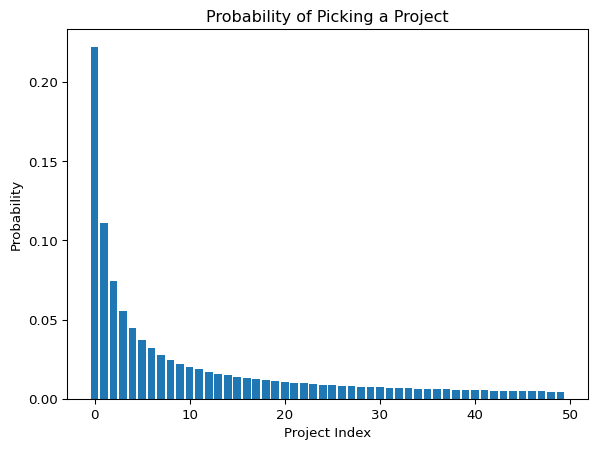

In [3]:
def zipf_pmf(k, N):
    """Return the value of a Zipf probability mass function"""
    return 1 / k * 1 / np.sum(1 / np.arange(1, num_projects + 1))

project_probabilities = zipf_pmf(np.arange(1, num_projects + 1), num_projects)
fig, ax = plt.subplots()
ax.bar(np.arange(num_projects), project_probabilities)
ax.set_ylabel("Probability")
ax.set_xlabel("Project Index")
_ = ax.set_title("Probability of Picking a Project")

We'll assume that students populate their preference list by picking from this distribution without replacement. 

In [4]:
trunc_ranks = []
for _ in range(num_students):
    trunc_ranks.append(np.random.choice(np.arange(num_projects), 5, replace=False, p=project_probabilities))

trunc_ranks = np.asarray(trunc_ranks).T

Now we can solve as before.

In [5]:
dissatisfaction_matrix = np.zeros((num_projects, num_students)) + omit_cost
student_vec = np.arange(num_students)
for idx, rank in enumerate(trunc_ranks):
    dissatisfaction_matrix[rank, student_vec] = idx
dissatisfaction_matrix /= omit_cost # normalize

objective = cp.Minimize(cp.trace(dissatisfaction_matrix.T @ assignment_matrix))

problem = cp.Problem(objective, constraints)
problem.solve()

student_dissatisfaction = np.diag(dissatisfaction_matrix.T @ assignment_matrix.value)
print(f"The most dissatisfaction a student has is {np.max(student_dissatisfaction):.2f}/1.0")

The most dissatisfaction a student has is 0.40/1.0


As expected, the worst case dissatisfaction did go up. But, you know what I can't get over?

In [6]:
print(f"Number of students that didn't get anything on their list: {np.sum(student_dissatisfaction == 1)}.")

Number of students that didn't get anything on their list: 0.


<!-- REFERENCES -->
<!-- ::: {#refs}
## References
::: -->
<!-- --- -->

<!-- EDIT HISTORY -->
<!-- ::: {.callout-note}
## Edit History

- **2025-07-31**: Reformatted for new site
::: -->

---

<!-- COMMENTS/REACTIONS -->